# **🤗 Contradictory, My Dear Watson ([캐글 경진대회](https://www.kaggle.com/competitions/contradictory-my-dear-watson?rvi=1))**

## **1. 라이브러리 가져오기**

In [1]:
!pip install evaluate
!pip install wandb

import torch
import numpy as np
import tensorflow as tf

# 2. 데이터셋 불러오기 (.csv 파일 I/O)
import pandas as pd

# 3. 데이터 시각화
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# 4. 데이터 전처리
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# 5. 모델 구축
import torch.nn as nn
import evaluate
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, XLMRobertaModel

# 6. 모델 훈련
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, EarlyStoppingCallback

In [2]:
# GPU 환경 설정
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("복제 수 : ", strategy.num_replicas_in_sync)

In [3]:
# 환경 변수 설정
import os
os.environ["WANDB_API_KEY"] = "0"

In [4]:
# 버전 에러 방지
import warnings
warnings.filterwarnings("ignore")

! pip install -U accelerate
! pip install -U transformers

## **2. 데이터셋 불러오기**

In [5]:
train_data = pd.read_csv("https://raw.githubusercontent.com/jumincho/Contradictory-My-Dear-Watson/main/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/jumincho/Contradictory-My-Dear-Watson/main/test.csv")

In [6]:
# 데이터셋 구조 확인
display(train_data.info())
display(train_data.head())

display(test_data.info())
display(test_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


None

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


None

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


## **3. 데이터 시각화**

In [7]:
# train_data language 분포
labels, frequencies = np.unique(train_data.language.values, return_counts=True)
fig1 = px.pie(values=frequencies, names=labels, title="train_data language 분포", color_discrete_sequence=px.colors.sequential.Plotly3)
fig1.show()

# test_data language 분포
labels, frequencies = np.unique(test_data.language.values, return_counts=True)
fig2 = px.pie(values=frequencies, names=labels, title="test_data language 분포", color_discrete_sequence=px.colors.sequential.Plotly3)
fig2.show()

In [8]:
# train_data label 분포
label_count = train_data["label"].value_counts().sort_index()
label_names = ["수반(0)","중립(1)","모순(2)"]
label_count.index = label_names
fig3 = go.Figure([go.Bar(x=label_names, y=label_count, marker_color="skyblue")])
fig3.update_layout(title_text="train_data label 분포", xaxis_title_text="label", yaxis_title_text="count")
fig3.show()

<Axes: xlabel='premise_text_length', ylabel='Count'>

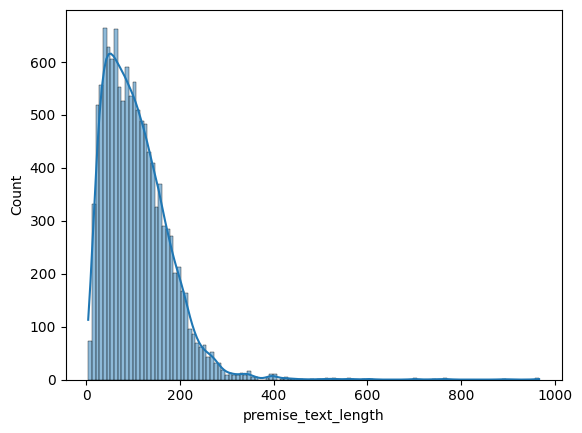

In [9]:
# train_data premise 데이터 길이 분포
train_data["premise_text_length"] = train_data["premise"].apply(len)
sns.histplot(train_data,x="premise_text_length", kde=True)

<Axes: xlabel='hypothesis_text_length', ylabel='Count'>

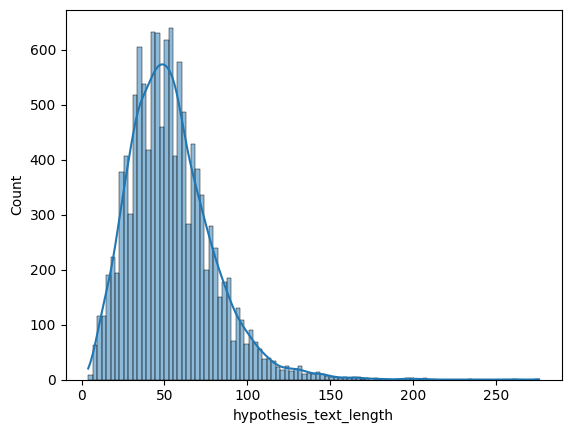

In [10]:
# train_data hypothesis 데이터 길이 분포
train_data["hypothesis_text_length"] = train_data["hypothesis"].apply(len)
sns.histplot(train_data,x="hypothesis_text_length", kde=True)

## **4. 데이터 전처리**

In [11]:
# 불필요한 열 제거
train_data = train_data.drop(labels=["language","lang_abv","premise_text_length","hypothesis_text_length"], axis=1)
test_data = test_data.drop(labels=["language","lang_abv"], axis=1)

In [12]:
# 데이터 분할 및 변환 (과적합 방지, 일반화 개선)
train_df, val_df = train_test_split(train_data, test_size=0.25, random_state=201818786)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_data)

ds = DatasetDict()
ds["train"] = train_ds
ds["validation"] = val_ds
ds["test"] = test_ds

## **5. 모델 구축 ([XLM-RoBERTa 사용](https://huggingface.co/symanto/xlm-roberta-base-snli-mnli-anli-xnli))**

In [13]:
# 토크나이저 불러오기
model_name = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [14]:
# 토크나이징 수행 함수
def tokenizer_sentence(data):
    return tokenizer(data["premise"], data["hypothesis"], truncation=True)

In [15]:
# 데이터 토큰화
tokenized_ds = ds.map(tokenizer_sentence, batched=True)

Map:   0%|          | 0/9090 [00:00<?, ? examples/s]

Map:   0%|          | 0/3030 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

In [16]:
# 데이터 패딩 처리
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
# 모델 설계
class CustomXLMRobertaModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomXLMRobertaModel, self).__init__()
        model_name = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"
        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.25)
        self.classifier = nn.Sequential(nn.Linear(768,512), nn.LayerNorm(512), nn.ReLU(), nn.Dropout(0.25), nn.Linear(512, num_labels))
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits

In [18]:
# 클래스 인스턴스 생성 및 모델에 할당
model = CustomXLMRobertaModel(num_labels=3)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at symanto/xlm-roberta-base-snli-mnli-anli-xnli and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **6. 모델 훈련 ([Trainer 사용](https://huggingface.co/docs/transformers/main_classes/trainer))([Early Stopping 사용](https://huggingface.co/docs/transformers/main_classes/callback))**

In [19]:
# TrainingArguments 인스턴스 생성 및 평가 지표 함수 생성
training_args = TrainingArguments("/content", optim="adamw_torch", num_train_epochs=5, evaluation_strategy="epoch",
                                  logging_dir='./logs', logging_steps=500, report_to="none")
# load_best_model_at_end=True

f1_metric = load_metric("f1")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="micro")
    }

In [20]:
# Trainer 클래스 정의 (Early Stopping 콜백 함수 사용 → 과적합 방지)
trainer = Trainer(
    model, args=training_args, train_dataset=tokenized_ds["train"], eval_dataset=tokenized_ds["validation"], data_collator=data_collator,
    tokenizer=tokenizer, compute_metrics=compute_metrics
)
# callbacks=[EarlyStoppingCallback(3)]

In [21]:
# 환경 변수 설정
os.environ["WANDB_DISABLED"] = "false"

In [22]:
# Trainer 클래스를 사용한 모델 훈련
trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.668300,0.572101,0.769307,{'f1': 0.7693069306930693}
2,0.496600,0.737841,0.786799,{'f1': 0.7867986798679868}
3,0.375400,0.874883,0.815182,{'f1': 0.815181518151815}
4,0.202200,0.989910,0.826403,{'f1': 0.8264026402640264}
5,0.120200,1.105240,0.832673,{'f1': 0.8326732673267326}


TrainOutput(global_step=5685, training_loss=0.37179970384797406, metrics={'train_runtime': 1544.6095, 'train_samples_per_second': 29.425, 'train_steps_per_second': 3.681, 'total_flos': 0.0, 'train_loss': 0.37179970384797406, 'epoch': 5.0})

## **7. 모델 예측 및 제출**

In [23]:
# 모델 예측 수행
predictions = trainer.predict(tokenized_ds["test"])

In [24]:
# 로짓 값 확률로 변환
logits = torch.from_numpy(predictions.predictions)
probs = torch.softmax(logits, -1).tolist()

In [25]:
# 예측 결과 포맷 맞추기
outputs = [(ds["test"]["id"][index], prob.index(max(prob))) for index, prob in enumerate(probs)]

In [26]:
# 제출용 파일 생성
submission = pd.read_csv("https://raw.githubusercontent.com/jumincho/Contradictory-My-Dear-Watson/main/sample_submission.csv")
submission["prediction"] = pd.DataFrame(outputs)[1]
submission.to_csv("submission.csv", index=False)